In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define object for moving point charge

In [2]:
from numbers import Real

import numpy as np

from charge.time import tr_arr

class Moving_Point_Charge(object):
    
    # System spatial dimension
    dim = 3
    
    # light speed in atomic unit
    c = 1.0 / 0.0072973525693
    
    def __init__(self, q, rs, vs):
        for _arg in (rs, vs): self._check_particle_vector_callable(_arg)
        assert isinstance(q, Real)
        self.q, self.rs, self.vs = q, rs, vs
        
        
    def _check_particle_vector_callable(self, arg):
        assert callable(arg)
        _vec = arg(0)
        assert isinstance(_vec, np.ndarray)
        assert _vec.shape == (self.dim,)
        
        
    def potentials_xyz(self, xyz, t):
        """
        Evaluate Liénard–Wiechert scalar and vector potentials 
        at given space-time point(s) in atomic unit
        """
        try: _xyz = np.array(xyz)
        except: raise TypeError()
        
        _tr_arr = tr_arr(_xyz, t, self.rs, self.c)  # retarded time in atomic unit
        
        _rs, _vs = np.empty_like(_xyz), np.empty_like(_xyz)
        
        for _ind, _tr in np.ndenumerate(_tr_arr):
            _rs[_ind], _vs[_ind] = self.rs(_tr), self.vs(_tr)
        
        _beta = _vs / self.c  # velocity relative to the light speed
        _rela_xyz = _xyz - _rs
        _dist = np.sqrt(np.square(_rela_xyz).sum(axis=-1))
#         assert np.all(_dist > 0)
        
        _denom = _dist - (_rela_xyz * _beta).sum(axis=-1)
        _scalarpot = self.q / _denom  # in atomic unit
        
        _vectorpot = np.moveaxis(np.moveaxis(_beta,-1,0) / self.c * _scalarpot,0,-1)
        
        return _scalarpot, _vectorpot
    
    
    def potentials(self, x, y, z, t):
        try: _xyz = np.moveaxis(np.array((x,y,z)), 0, -1)
        except: raise Exception("Failed to construct coordinate array")
            
        _scalarpot_xyz, _vectorpot_xyz = self.potentials_xyz(_xyz, t)
        
        # since it is scalar, dimension axis is absent, 
        # thus there's no need for axis swapping.
        _scalarpot = _scalarpot_xyz  
        
        _vectorpot = np.moveaxis(_vectorpot_xyz, -1, 0)
        
        return _scalarpot, _vectorpot
        
    
    def scalarpot_xyz(self, xyz, t):
        """
        Evaluate Liénard–Wiechert scalar potential 
        at given space-time point(s) in atomic unit
        """
        _scalarpot_xyz, _ = self.potentials_xyz(xyz, t)
        return _scalarpot_xyz
    
    
    def scalarpot(self, x, y, z, t):
        try: _xyz = np.moveaxis(np.array((x,y,z)), 0, -1)
        except: raise Exception("Failed to construct coordinate array")
        return self.scalarpot_xyz(_xyz, t)
    

# Define a particle

In [3]:
c = Moving_Point_Charge.c

t0, t1 = -0.4, -0.3

r0 = np.array([-1.0, 0.0, 0.0])

v0 = np.array([0.0, 0.0, 0.0])
v1 = np.array([0.8 * c, 0.0, 0.0])

a0 = (v1 - v0) / (t1 - t0)

v1 = v0 + a0*(t1-t0)
r1 = r0 + v0*(t1-t0) + 0.5 * a0*(t1-t0)**2

def ap(t):
    if t < t0: return np.array([0.0, 0.0, 0.0])
    elif (t0 <= t) and (t < t1): return a0
    else: return np.array([0.0, 0.0, 0.0])

def vp(t):
    if t < t0: return v0
    elif (t0 <= t) and (t < t1): return v0 + a0*(t-t0)
    else: return v1
    
def rp(t):
    if t < t0: return r0 + v0*(t-t0)
    elif (t0 <= t) and (t < t1): return r0 + v0 * (t - t0) + 0.5 * a0 * (t-t0)**2
    else: return r1 + v1 *(t-t1)
    
# as_t = lambda t: a0
# vs_t = lambda t: v0 + a0 * (t - t0)
# rs_t = lambda t: r0 + v0 * (t - t0) + 0.5 * a0 * (t - t0)**2

beta_t = lambda t: vp(t) / c

## Plot the trajectory

In [4]:
t_arr = np.linspace(t0 - 0.2*(t1-t0), t1 + 0.5*(t1-t0), 51)
r_x = np.array([(rp(t)*np.array([1,0,0])).sum() for t in t_arr])
v_x = np.array([(vp(t)*np.array([1,0,0])).sum() for t in t_arr])
a_x = np.array([(ap(t)*np.array([1,0,0])).sum() for t in t_arr])
beta_x = np.array([(beta_t(t)*np.array([1,0,0])).sum() for t in t_arr])

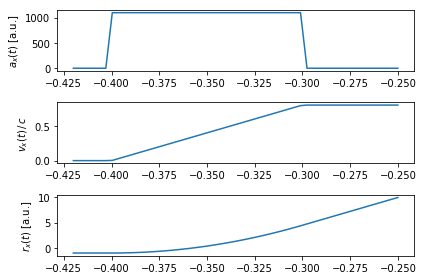

In [5]:
figt, (axa, axv, axr) = plt.subplots(nrows=3)
axa.plot(t_arr, a_x), axa.set_ylabel(r"$a_{x}(t)$ [a.u.]")
axv.plot(t_arr, beta_x), axv.set_ylabel(r"$v_{x}(t)\,/\,c$")
axr.plot(t_arr, r_x), axr.set_ylabel(r"$r_{x}(t)$ [a.u.]")
figt.tight_layout()
# figt.savefig("particle-traj-test-1.png")

## Construct a particle

In [6]:
q1 = Moving_Point_Charge(1.0, rp, vp)

# Evaluate the potentials

In [7]:
xp_min, xp_max = rp(t_arr[0])[0], rp(t_arr[-1])[0]
x_min, x_max = xp_min - 0.2 * (xp_max-xp_min), xp_max + 0.2 * (xp_max-xp_min)

In [8]:
x_arr = np.linspace(x_min,x_max,101)
y_arr = np.linspace(-2,2,41)

x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')
z_grid = np.zeros_like(x_grid)

In [9]:
t_eval = t_arr[0] + 0.8 * (t_arr[-1] - t_arr[0])

scalpot_grid = q1.scalarpot(x_grid, y_grid, z_grid, t=t_eval)

# scalpot_grid, vecpot_grid = q1.potentials(x_grid, y_grid, z_grid, t=t_eval)

In [10]:
vp(t_eval)

array([109.62879927,   0.        ,   0.        ])

# Plot

In [11]:
from vis.plot import construct_catesian_mesh_for_pcolormesh
x_color_grid, y_color_grid = construct_catesian_mesh_for_pcolormesh(x_arr, y_arr)
z_color_grid = np.zeros_like(x_grid)

In [12]:
vmax = np.quantile(scalpot_grid, 0.975)
vmin = np.quantile(scalpot_grid, 0.025)
from matplotlib.colors import Normalize
norm = Normalize(vmin, vmax)

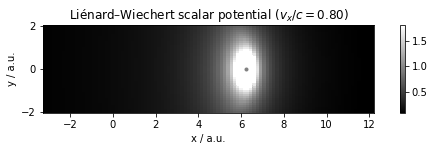

In [13]:
fig, ax = plt.subplots(figsize=(8,2))

# Plot scalar potential
quad = ax.pcolormesh(x_color_grid, y_color_grid, scalpot_grid, 
                     cmap='gray', norm=norm)
ax.set_aspect(1.0)
ax.set_xlabel("x / a.u."), ax.set_ylabel("y / a.u.")

# Plot the particle
xp, yp, zp = rp(t_eval)
ax.plot(xp, yp, '.', color='gray')

# ax.set_title(r"Liénard–Wiechert scalar potential $(v\,/\,c={:.2f})$".format(beta_t(t_eval)))
ax.set_title(r"Liénard–Wiechert scalar potential ($v_{{x}}/c={:.2f}$)".format(vp(t_eval)[0]/c))
cb = fig.colorbar(quad, ax=ax)
fig.tight_layout()

In [14]:
fig_filename = "scalarpot-accelerated-test-0.png"
print(fig_filename)
# fig.savefig(fig_filename)

scalarpot-accelerated-test-0.png
